In [6]:
import arepo
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl

from numba import njit

from joblib import Parallel, delayed
import pickle

In [3]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [165]:
@njit
def rodrigues_formula(k, v, theta):
    N = v.shape[0]
    v_rot = np.zeros(np.shape(v))
    
    ctheta = np.cos(theta)
    stheta = np.sin(theta)
    
    for i in range(N):
        v_rot[i] = v[i] * ctheta + np.cross(k, v[i]) * stheta + k * (np.dot(k, v[i])) * (1-ctheta)
    
    return v_rot

In [343]:
def get_COM(pos, vel, rmin=1, rmax=20, rfac=0.9):
    COM = np.mean(pos, axis=0)
    r = np.linalg.norm(pos-COM, axis=1)
    
    rcut = rmax
    while rcut > rmin:
        COM = np.mean(pos[r<rcut], axis=0)
        r = np.linalg.norm(pos-COM, axis=1)
        rcut *= rfac
    
    COMV = np.mean(vel[r<rcut], axis=0)
    
    return COM, COMV

def get_AngMom(pos, vel, mass, COM, COMV, rcut=8):
    r = np.linalg.norm(pos-COM)
    key = r < rcut
    
    ang = np.cross(pos-COM, vel-COMV)
    ang = np.sum(ang, axis=0)
    ang *= mass
    
    return ang

In [361]:
def get_in_GSE(sn, sn0, center):
    r = np.linalg.norm(sn0.part2.pos - center, axis=1)
    in_GSE0 = r > 40
    in_MW0 = np.logical_not(in_GSE0)
    GSE_ID_min = np.min(sn0.part2.id[in_GSE0])
    GSE_ID_max = np.max(sn0.part2.id[in_GSE0])

    MW_ID_min = np.min(sn0.part2.id[in_MW0])
    MW_ID_max = np.max(sn0.part2.id[in_MW0])
    # print(np.min(sn_rn0.part2.id[in_GSE]), np.max(sn_rn0.part2.id[in_GSE]))
    # print(np.min(sn_rn0.part2.id[in_MW]), np.max(sn_rn0.part2.id[in_MW]))
    
    in_GSE = np.logical_and(sn.part2.id >= GSE_ID_min, sn.part2.id <= GSE_ID_max)
    in_MW = np.logical_and(sn.part2.id >= MW_ID_min, sn.part2.id <= MW_ID_max)
    
    return in_MW, in_GSE

def get_Lz(sn, sn0, center=np.array([0, 0, 0])):
    
    # plt.scatter(sn_rn0.part2.pos[:,0], sn_rn0.part2.pos[:,1])
    in_MW, in_GSE = get_in_GSE(sn, sn0, center)
    
    pos_MW = sn.part2.pos[in_MW]
    vel_MW = sn.part2.vel[in_MW]
    
    pos_GSE = sn.part2.pos[in_GSE]
    vel_GSE = sn.part2.vel[in_GSE]
    
    MW_COM, MW_COMV = get_COM(pos_MW, vel_MW)
    GSE_COM, GSE_COMV = get_COM(pos_GSE, vel_GSE)
    
    print('GSE_COM', GSE_COM-MW_COM)
    print('GSE_COMV', GSE_COMV-MW_COMV)
    
    if sn.MassTable[2] > 0:
        mass_GSE = sn.MassTable[2]
    else:
        mass_GSE = sn.part2.mass[in_GSE][0]

    MW_AngMom = get_AngMom(pos_MW, vel_MW, mass_GSE, MW_COM, MW_COMV)

    ang_mom = MW_AngMom
    angmom_dir = ang_mom/np.linalg.norm(ang_mom)
    theta = np.arccos(np.dot(angmom_dir, np.array([0, 0, 1])))
    k = np.cross(ang_mom, np.array([0, 0, 1.]))
    k /= np.linalg.norm(k)
    
    # print('MW_COM', MW_COM)
    # print('MW_COMV', MW_COMV)
    # print('MW_AngMom', MW_AngMom)

    pos_GSE = sn.part2.pos[in_GSE] - MW_COM
    vel_GSE = sn.part2.vel[in_GSE] - MW_COMV

    pos_GSE_rot = rodrigues_formula(k, pos_GSE.astype(np.float64), theta)
    vel_GSE_rot = rodrigues_formula(k, vel_GSE.astype(np.float64), theta)

    Lz = np.cross(pos_GSE_rot, vel_GSE_rot)[:,2]
    
    return Lz, vel_GSE_rot

In [560]:
sn_f = arepo.Snapshot(basepath+'runs/fgGSE0.5_fgMW0.5/lvl4/output',
                      600, combineFiles=True)
sn_f0 = arepo.Snapshot(basepath+'runs/fgGSE0.5_fgMW0.5/lvl4/output',
                       0, combineFiles=True)

print(sn_f.Time)

3.0


In [586]:
# hi res
#sn_rn = arepo.Snapshot('/n/holystore01/LABS/conroy_lab/Lab/rnaidu/sims'+
#                       '/fiducial/129_129_50_pro_165/snapshot_500')
#sn_rn0 = arepo.Snapshot('/n/holystore01/LABS/conroy_lab/Lab/rnaidu/sims'+
#                        '/fiducial/129_129_50_pro_165/snapshot_000')

# lo res
sn_rn = arepo.Snapshot('/n/holystore01/LABS/conroy_lab/Lab/rnaidu/sims/'+
                     'z2merger_M1_UM/grid/129_129_50_pro_165/snapshot_100')
sn_rn0 = arepo.Snapshot('/n/holystore01/LABS/conroy_lab/Lab/rnaidu/sims/'+
                     'z2merger_M1_UM/grid/129_129_50_pro_165/snapshot_000')

print(sn_rn.Time)
print(sn_rn.part2.mass[0]*1E10/1E4)

9.999999962747097
10.00234351522522


In [587]:
sn_rn_arepo = arepo.Snapshot(basepath + 'runs/RNics/lvl4/output', 2000, combineFiles=True)
sn_rn0_arepo = arepo.Snapshot(basepath + 'runs/RNics/lvl4/output', 0, combineFiles=True)

print(sn_rn_arepo.Time)

10.0


In [567]:
sn = arepo.Snapshot(basepath + 'runs/MWN0_GSEN0/lvl4/output', 2000, combineFiles=True)
sn0 = arepo.Snapshot(basepath + 'runs/MWN0_GSEN0/lvl4/output', 0, combineFiles=True)
print(sn.Time, sn0.BoxSize)

10.0 600.0


In [588]:
Lz, vGSE = get_Lz(sn, sn0)
Lz_f, vGSE_f = get_Lz(sn_f, sn_f0, center=np.array([200, 200, 200]))
Lz_rn, vGSE_rn = get_Lz(sn_rn, sn_rn0)
Lz_rn_arepo, vGSE_rn_arepo = get_Lz(sn_rn_arepo, sn_rn0_arepo)

GSE_COM [-0.03611714  0.11042999 -0.15930415]
GSE_COMV [  4.11011671 -29.18689529  30.74925196]
GSE_COM [-0.27580595 -8.3080131  12.39671477]
GSE_COMV [-32.83114624   8.02376938  24.08968353]
GSE_COM [ 0.23925781 -0.24224854 -0.00117493]
GSE_COMV [-24.961687  32.596146 -44.02635 ]
GSE_COM [ 0.12792787  0.25678487 -0.32098446]
GSE_COMV [ 16.31359003 -37.66667192  45.99341382]


Text(0.5, 0, 'Lz [1E3 kpc km/s]')

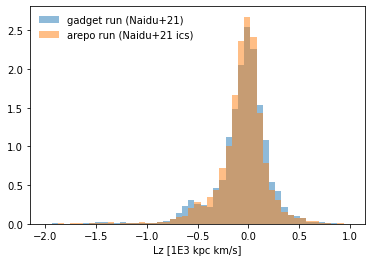

In [589]:
bins = np.linspace(-2, 1, 50)
# plt.hist(Lz/1E3, alpha=0.5, density=True, bins=bins, label='arepo run');
# plt.hist(Lz_f/1E3, alpha=0.5, density=True, bins=bins);
plt.hist(Lz_rn/1E3, alpha=0.5, density=True, bins=bins, label='gadget run (Naidu+21)');
plt.hist(Lz_rn_arepo/1E3, alpha=0.5, density=True, bins=bins, label='arepo run (Naidu+21 ics)');
plt.legend(frameon=False)
plt.xlabel('Lz [1E3 kpc km/s]')

In [583]:
ics = arepo.Snapshot('/n/holystore01/LABS/conroy_lab/Lab/rnaidu/sims/'+
                     'z2merger_M1_UM/grid/129_129_50_pro_165/129_129_50_pro_165.dat')

In [584]:
print(ics.part1.mass[0]*1E10)

95810.47379469965


In [320]:
print(np.median(vGSE_rn, axis=0))

[ 95.69941491  46.19291746 -94.18742739]


In [360]:
#sn_f0, sn_rn0, sn0

In [387]:
def print_info(sn, sn0, center):
    in_MW, in_GSE = get_in_GSE(sn0, sn0, center)
    
    # get MW COM and COMV
    pos_MW = sn0.part2.pos[in_MW]
    vel_MW = sn0.part2.vel[in_MW]
    
    pos_GSE = sn0.part2.pos[in_GSE]
    vel_GSE = sn0.part2.vel[in_GSE]
    
    MW_COM, MW_COMV = get_COM(pos_MW, vel_MW)
    GSE_COM, GSE_COMV = get_COM(pos_GSE, vel_GSE)
    
    # get MW mass and gas mass
    
    if sn.MassTable[2] > 0:
        MW_mass = len(np.where(in_MW)[0]) * sn.MassTable[2]
    else:
        MW_mass = np.sum(sn.part2.mass[in_MW])
    
    if sn0.NumPart_Total[0] > 0:
        rgas = np.linalg.norm(sn0.part0.pos - MW_COM, axis=1)
        gas_in_MW = rgas < 40
        MW_mass_gas = np.sum(sn0.part0.mass[gas_in_MW])
        print('MW gas mass:', MW_mass_gas)
    
    print('MW mass:', MW_mass)
    
    # get disk enclosed within 2kpc
    rstar = np.linalg.norm(sn0.part2.pos - MW_COM, axis=1)
    in_2kpc = rstar < 2
    if sn0.MassTable[2] > 0:
        print('MW disk mass in 2kpc:', sn0.MassTable[2] * len(np.where(in_2kpc)[0]))
    else:
        print('MW disk mass in 2kpc:', np.sum(sn0.part2.mass[in_2kpc]))
    
    if sn0.NumPart_Total[0] > 0:
        gas_in_2kpc = rgas < 2
        MW_mass_gas = np.sum(sn0.part0.mass[gas_in_2kpc])
        print('MW gas disk mass in 2kpc:', MW_mass_gas)
    
    # halo mass in 2kpc
    rhalo = np.linalg.norm(sn0.part1.pos - MW_COM, axis=1)
    in_20kpc = rhalo < 20
    if sn0.MassTable[1] > 0:
        print('halo mass in 20kpc:', sn0.MassTable[1] * len(np.where(in_20kpc)[0]))
    else:
        print('halo mass in 20kpc:', np.sum(sn0.part1.mass[in_20kpc]))
    

In [388]:
print('rohan run')
print_info(sn_rn, sn_rn0, center=np.array([0, 0, 0]))
print("\nfg05 run")
print_info(sn_f, sn_f0, center=np.array([200, 200, 200]))
# print_info(sn_rn, sn_rn0, center=np.array([0, 0, 0]))

rohan run
MW mass: 0.5989141
MW disk mass in 2kpc: 0.2851099
halo mass in 20kpc: 5.2629733

fg05 run
MW gas mass: 0.2995105
MW mass: 0.299488509651193
MW disk mass in 2kpc: 0.2263403571967584
MW gas disk mass in 2kpc: 0.22973809
halo mass in 20kpc: 5.32506372819229


In [420]:
def get_circular_velocity_curve(sn, sn0, center):
    in_MW, in_GSE = get_in_GSE(sn0, sn0, center)
    
    # get MW COM and COMV
    pos_MW = sn0.part2.pos[in_MW]
    vel_MW = sn0.part2.vel[in_MW]
    
    pos_GSE = sn0.part2.pos[in_GSE]
    vel_GSE = sn0.part2.vel[in_GSE]
    
    MW_COM, MW_COMV = get_COM(pos_MW, vel_MW)
    GSE_COM, GSE_COMV = get_COM(pos_GSE, vel_GSE)
    
    dr = 0.5
    rmax = dr
    
    r = {}
    rGSE = {}
    for ptype in [0, 1, 2]:
        if sn0.NumPart_Total[ptype] > 0:
            part = getattr(sn0, 'part'+str(ptype))
            r[ptype] = np.linalg.norm(part.pos - MW_COM, axis=1)
            rGSE[ptype] = np.linalg.norm(part.pos - GSE_COM, axis=1)
    
    rmax_list = []
    Menc_list = []
    MencGSE_list = []
    while rmax < 80:
        Menc = 0.0
        MencGSE = 0.0
        for ptype in r.keys():
            part = getattr(sn0, 'part'+str(ptype))
            in_rmax = r[ptype] < rmax
            in_rmaxGSE = rGSE[ptype] < rmax
            
            if sn0.MassTable[ptype] > 0:
                Menc += len(np.where(in_rmax)[0]) * sn0.MassTable[ptype]
                MencGSE += len(np.where(in_rmaxGSE)[0]) * sn0.MassTable[ptype]
            else:
                Menc += np.sum(part.mass[in_rmax])
                MencGSE += np.sum(part.mass[in_rmaxGSE])
            
        Menc_list.append(Menc)
        MencGSE_list.append(MencGSE)
        rmax_list.append(rmax)
        
        rmax += dr
    
    return np.array(rmax_list), np.array(Menc_list), np.array(MencGSE_list)
    

In [421]:
r, Menc, MencGSE = get_circular_velocity_curve(sn_rn, sn_rn0, np.array([0, 0, 0]))
r_f, Menc_f, MencGSE_f = get_circular_velocity_curve(sn_f, sn_f0, np.array([200, 200, 200]))


(0.0, 80.0)

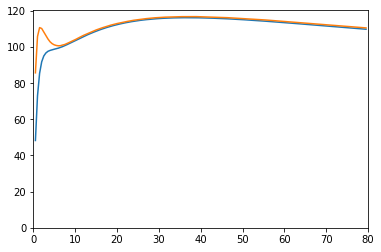

In [422]:
G = 43018.7
plt.plot(r, np.sqrt(G*Menc/r))
plt.plot(r_f, np.sqrt(G*Menc_f/r_f))
plt.ylim(0, None)
plt.xlim(0, 80)

(0.0, 80.0)

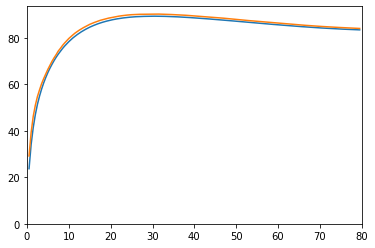

In [419]:
G = 43018.7
plt.plot(r, np.sqrt(G*MencGSE/r))
plt.plot(r_f, np.sqrt(G*MencGSE_f/r_f))
plt.ylim(0, None)
plt.xlim(0, 80)

[(-100.0, 100.0), (-100.0, 100.0)]

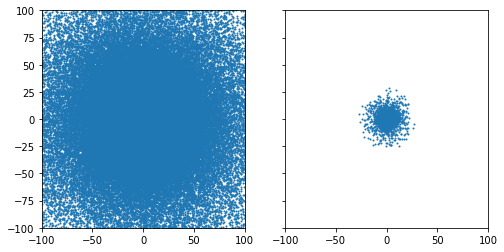

In [425]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].scatter(sn_rn0.part3.pos[:,0], sn_rn0.part3.pos[:,1], s=1)
ax[1].scatter(sn_f0.part3.pos[:,0]-200, sn_f0.part3.pos[:,1]-200, s=1)
ax[0].set(xlim=(-100, 100), ylim=(-100, 100))

### compare new MW ICs to rohan's ICs

In [434]:
fpath = '/n/holystore01/LABS/conroy_lab/Lab/rnaidu/code/GALIC/Model-MWz2_M1_smaller/snap_010'
ics_rn = arepo.Snapshot(fpath)

fpath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/ics/fgGSE0.0_fgMW0.0/lvl4/MW_ICs.dat'
ics_f = arepo.Snapshot(fpath)

Warning end of file '/n/holystore01/LABS/conroy_lab/Lab/rnaidu/code/GALIC/Model-MWz2_M1_smaller/snap_010' not reached yet, but unknowen fields ahead. Thus some items might be missing on the snapshot object.


In [463]:
def compute_stellar_surf_dens(ics, ptype=2, Rmax=20):
    part = getattr(ics, 'part'+str(ptype))
    R = np.linalg.norm(part.pos[:,:2], axis=1)
    
    Rmin = 0.0
    dR = 0.5
    
    Rlist = []
    Sigmalist = []
    
    while Rmin < Rmax:
        key = np.logical_and(R > Rmin, R < Rmin + dR)
        
        if ics.MassTable[ptype] > 0:
            Menc = len(np.where(key)[0]) * ics.MassTable[ptype]
        else:
            Menc = np.sum(part.mass[key])
        
        area = np.pi * ((Rmin + dR)**2 - Rmin**2)
        
        Rlist.append(Rmin + dR/2.)
        Sigmalist.append(Menc/area)
        
        Rmin += dR
    
    return np.array(Rlist), np.array(Sigmalist)
        

In [464]:
R_rn, Sigma_rn = compute_stellar_surf_dens(ics_rn)
R_f, Sigma_f = compute_stellar_surf_dens(ics_f)

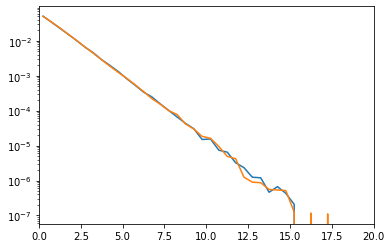

In [465]:
plt.plot(R_rn, Sigma_rn)
plt.plot(R_f, Sigma_f)
plt.xlim(0, 20)
plt.yscale('log')

In [466]:
R_rn, Sigma_rn = compute_stellar_surf_dens(ics_rn, 3)
R_f, Sigma_f = compute_stellar_surf_dens(ics_f, 3)

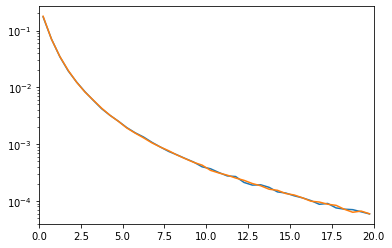

In [467]:
plt.plot(R_rn, Sigma_rn)
plt.plot(R_f, Sigma_f)
plt.xlim(0, 20)
plt.yscale('log')

In [468]:
R_rn, Sigma_rn = compute_stellar_surf_dens(ics_rn, 1, 100)
R_f, Sigma_f = compute_stellar_surf_dens(ics_f, 1, 100)

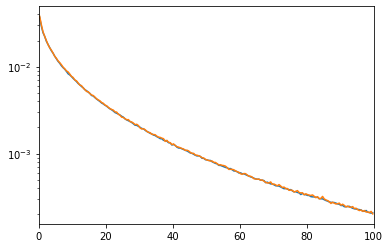

In [469]:
plt.plot(R_rn, Sigma_rn)
plt.plot(R_f, Sigma_f)
plt.xlim(0, 100)
plt.yscale('log')

### now for GSE

In [470]:
fpath = '/n/holystore01/LABS/conroy_lab/Lab/rnaidu/code/GALIC/Model-GEz2_UM_M1_9_10x/snap_010'
icsGSE_rn = arepo.Snapshot(fpath)

fpath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/ics/fgGSE0.0_fgMW0.0/lvl4/GSE_ICs.dat'
icsGSE_f = arepo.Snapshot(fpath)

Warning end of file '/n/holystore01/LABS/conroy_lab/Lab/rnaidu/code/GALIC/Model-GEz2_UM_M1_9_10x/snap_010' not reached yet, but unknowen fields ahead. Thus some items might be missing on the snapshot object.


In [471]:
R_rn, Sigma_rn = compute_stellar_surf_dens(icsGSE_rn)
R_f, Sigma_f = compute_stellar_surf_dens(icsGSE_f)

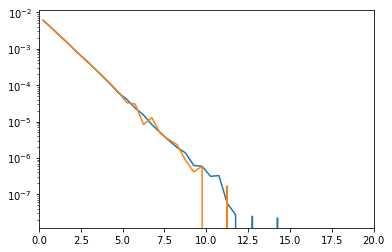

In [472]:
plt.plot(R_rn, Sigma_rn)
plt.plot(R_f, Sigma_f)
plt.xlim(0, 20)
plt.yscale('log')

In [475]:
R_rn, Sigma_rn = compute_stellar_surf_dens(icsGSE_rn, 1, 100)
R_f, Sigma_f = compute_stellar_surf_dens(icsGSE_f, 1, 100)

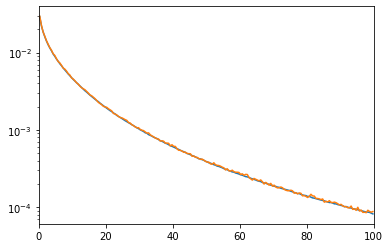

In [476]:
plt.plot(R_rn, Sigma_rn)
plt.plot(R_f, Sigma_f)
plt.xlim(0, 100)
plt.yscale('log')

In [477]:
ics_f.MassTable

array([0.00000000e+00, 3.00081358e-05, 6.00165347e-06, 6.00163629e-06,
       0.00000000e+00, 0.00000000e+00])

In [478]:
icsGSE_f.MassTable

array([0.00000000e+00, 3.00081403e-05, 6.00110705e-06, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

## now check merged ICs

In [482]:
fpath = '/n/holystore01/LABS/conroy_lab/Lab/rnaidu/sims/z2merger_M1_UM/grid/'+ \
                '129_129_50_pro_165/129_129_50_pro_165.dat'
icsmerge_rn = arepo.Snapshot(fpath)

fpath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/ics/fgGSE0.0_fgMW0.0/lvl4/ics.hdf5'
icsmerge_f = arepo.Snapshot(fpath)

[(-150.0, 50.0), (-100.0, 100.0)]

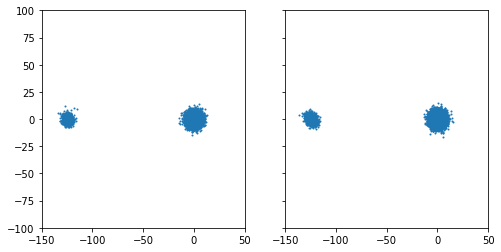

In [484]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].scatter(icsmerge_rn.part2.pos[:,0], icsmerge_rn.part2.pos[:,1], s=1)
ax[1].scatter(icsmerge_f.part2.pos[:,0], icsmerge_f.part2.pos[:,1], s=1)
ax[0].set(xlim=(-150, 50), ylim=(-100, 100))

In [519]:
def print_GSE_prop(ics, ptype=2):
    part = getattr(ics, 'part'+str(ptype))
    r = np.linalg.norm(part.pos, axis=1)
    in_GSE = r > 50
    
    COM = np.mean(part.pos[in_GSE], axis=0)
    print('COM: ', COM)
    
    vel = np.mean(part.vel[in_GSE], axis=0)
    print('vel:', vel)
    
    angmom = np.cross(part.pos[in_GSE], part.vel[in_GSE])[:,2]
    print('mean ang mom', np.mean(angmom)/1E3)
    
    if ics.MassTable[ptype] > 0:
        mass = ics.MassTable[ptype]
    else:
        mass = part.mass[in_GSE][0]
        
    ang_mom = mass * np.cross(part.pos[in_GSE]-COM, part.vel[in_GSE])
    ang_mom = np.sum(ang_mom, axis=0)
    print('ang mom:', ang_mom)
    

In [520]:
np.set_printoptions(suppress=True)

print('rnaidu ics')
print_GSE_prop(icsmerge_rn)

print("\nMakeNewDisk ics")
print_GSE_prop(icsmerge_f)

rnaidu ics
COM:  [-124.57772      -0.03180444   33.386116  ]
vel: [ 95.52089   45.409176 -75.06672 ]
mean ang mom -5.7445419921875
ang mom: [-1.2115622  -0.01831451 -4.5365252 ]

MakeNewDisk ics
COM:  [-124.61867      -0.00040985   33.396282  ]
vel: [ 96.349236  45.677246 -73.19984 ]
mean ang mom -5.7827958984375
ang mom: [-1.2159278  -0.32217067 -4.538272  ]


In [500]:
print_GSE_prop(icsmerge_rn, 1)
print_GSE_prop(icsmerge_f, 1)

COM:  [-48.07066     -0.33742654  14.075503  ]
vel: [ 36.74302   17.435343 -27.863905]
ang mom: [-19331.48 -75269.89 -72015.46]
COM:  [-49.719254     0.42441124  13.538977  ]
vel: [ 37.664135  17.973888 -28.619177]
ang mom: [-20936.906 -77906.35  -55699.223]
